# Single cell ATAC-Seq analysis data by 10x Cell Ranger


_Cell Ranger ATAC-Seq_ https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/algorithms/overview

Information about library.

<img src='assets/1.png' width=80%>

# Fragments file processing

In [1]:
import re

# Fragments file provided by cell ranger
fragments_file_gz = '/mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/atac/TWDB-T-CIML007-Baseline_NK_snATAC/outs/fragments.tsv.gz'

# BedTools doesn't work with gz file, so unzip it
!gunzip {fragments_file_gz}
fragments_file = re.sub('\.gz', '', fragments_file_gz)

# Print first line of fragments file
with open(fragments_file, 'r') as fin:        
    for line in fin:        
        print(line)
        break

gzip: /mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/atac/TWDB-T-CIML007-Baseline_NK_snATAC/outs/fragments.tsv.gz: No such file or directory
chr1	10073	10369	AGTCCGGGTCAACTGT-1	1



# Cell Calling

_Cell Ranger ATAC-Seq_

Given `peaks.bed` graphics of BARCODE overlaps with peaks.
<img src='assets/2.png' width=80%>

For each barcode, we have the record of mapped high-quality fragments that passed all filters (the fragments.tsv file). Having determined peaks prior to this, we use the number of fragments that overlap any peak regions, for each barcode, to separate the signal from noise. **This works better in practice as compared to naively using the number of fragments per barcode.** We first subtract a depth-dependent fixed count from all barcode counts to model whitelist contamination. This fixed count is the estimated number of fragments per barcode that originated from a different GEM, assuming a contamination rate of 0.02. Then we fit a mixture model of two negative binomial distributions to capture the signal and noise. Setting an odds ratio of 1000, we separate the barcodes that correspond to real cells from the non-cell barcodes.

**We use dumb threshold for now.**

In [2]:
# Intersect using bedtools rather than pybedtools, because they are too slow!
import tempfile
import pandas as pd
import numpy as np
import os
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()


def process_peaks_file(fragments_file, peaks_file, threshold=137):
    ! wc -l {peaks_file}

    idf = None
    ! wc -l {fragments_file}
    with tempfile.NamedTemporaryFile(prefix='intersection', suffix='.bed') as f:
        print('Compute intersection')
        ! bedtools intersect -wa -wb -a {fragments_file} -b {peaks_file} > {f.name}
        ! wc -l {f.name}
        idf = pd.read_csv(f.name, sep='\t', header=None)
        idf.columns = ['chr', 'start', 'end', 'barcode', 'reads', 'peak_chr', 'peak_start', 'peak_end']

    print('Compute unique barcode overlaps')
    pidf = pd.pivot_table(idf, values='reads', index=['barcode'], aggfunc='count')
    pidf.reset_index(level=0, inplace=True)

    counts = sorted(pidf['reads'], reverse=True)
    ns = range(1, len(counts) + 1)
    df_all = pd.DataFrame(data={'count': counts, 'n': ns})
    df_cells = df_all.loc[df_all['count'] >= threshold]
    df_noise = df_all.loc[df_all['count'] < threshold]
    print('Filtering cells by threshold', threshold)
    cells = set(pidf.loc[pidf['reads'] >= threshold]['barcode'])
    idfcells = idf.loc[[c in cells for c in idf['barcode']]]
    print('Estimated number of cells', len(df_cells))

    # create a new plot (with a title) using figure
    p = figure(plot_width=400, plot_height=400, title="Plots", x_range=(0, 6))
    p.line(np.log10(df_cells['n']), np.log10(df_cells['count']) , line_width=3, line_color='orange', legend='Cell')
    p.line(np.log10(df_noise['n']), np.log10(df_noise['count']) , line_width=3, line_color='blue', legend='Noise')
    p.legend.location = "center_right"
    p.legend.background_fill_color = "#fefefe"
    p.xaxis.axis_label = 'Barcodes'
    p.yaxis.axis_label = 'Fragments overlapping Peaks'
    show(p)
    
    return idfcells

Loading BokehJS ...

In [3]:
# 10x Cell ranger single cell ATAC-Seq
idf10x = process_peaks_file(
    fragments_file, '/mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/bam/peaks.bed',
    threshold=3000)

67086 /mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/bam/peaks.bed
77486512 /mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/atac/TWDB-T-CIML007-Baseline_NK_snATAC/outs/fragments.tsv
Compute intersection
56077745 /tmp/intersectionwk1jm1ph.bed
Compute unique barcode overlaps
Filtering cells by threshold 3000
Estimated number of cells 7412


In [4]:
# MACS2 processing like in scatac pipeline ATAC-Seq
# MACS2 --no-model --p 1e-4
# idfmacs = process_peaks_file(
#     fragments_file, '/mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/bam/macs2_p1e-4.narrowPeak',
#     threshold=20000)

In [5]:
# SPAN - --fragment 0 --keep-dup --bin 100
# idfspan = process_peaks_file(
#     fragments_file, 
#     '/mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/bam/span_f0_kd_bin100_fdr1.0E-6_gap5.bed',
#     threshold=2000)

# Peak-Barcode Matrix

_Cell Ranger ATAC-Seq_

We produce a count matrix consisting of the counts of fragment ends (or cut sites) within each peak region for each barcode. This is the raw peak-barcode matrix and it captures the enrichment of open chromatin per barcode. The matrix is then filtered to consist of only cell barcodes, which is then used in subsequent analysis such as dimensionality reduction, clustering and visualization.

In [6]:
idf = idf10x

print('Compute barcode overlaps with peaks')
pdf = pd.pivot_table(idf, values='reads', 
                     index=['peak_chr', 'peak_start', 'peak_end', 'barcode'], aggfunc=np.sum).reset_index()
pdf['peak'] = pdf['peak_chr'] + ':' + pdf['peak_start'].astype(str) + '-' + pdf['peak_end'].astype(str)
pdf.drop(columns=['peak_chr', 'peak_start', 'peak_end'], inplace=True)
pdf.head()

Compute barcode overlaps with peaks


barcode  reads                peak
0  AAAGATGCACTCCCAT-1      3  chr1:181389-181537
1  AACAGTCGTTGTGACT-1      2  chr1:181389-181537
2  AAGATAGAGGTAGGAA-1      5  chr1:181389-181537
3  AGCTGGCTCCAATAGC-1      1  chr1:181389-181537
4  AGCTGGCTCTGGACAT-1      1  chr1:181389-181537

In [7]:
fulldf = pd.pivot_table(pdf, index='peak', columns='barcode', values='reads').fillna(0)
# Remove extra labels from pivot_table columns
fulldf.columns = fulldf.columns.values
fulldf.index.name = None
fulldf.head()

AAACGAAAGACTAATG-1  AAACGAAAGAGGTGGG-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                 0.0                 0.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 0.0                 0.0   
chr10:100167463-100168096                 1.0                 0.0   

                           AAACGAAAGGGCTTCC-1  AAACGAAAGTATGGGC-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                 0.0                 0.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 0.0                 0.0   
chr10:100167463-100168096                 0.0                 0.0   

                           AAACGAAAGTGTTCCA-1  AAACGAAAGTTCGCGC-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                 1.0                 1.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 0.0                 0.0   
chr10:100167463-100168096                 0.0                 0.0   

                           AAACGAACAATAGTGA-1  AAACGAACACATATCG-1  \
chr10:100006265-100006798                 0.0                 1.0   
chr10:100009106-100010528                 0.0                 0.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 1.0                 0.0   
chr10:100167463-100168096                 0.0                 0.0   

                           AAACGAACACGCGTTG-1  AAACGAACATCCATAG-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                 0.0                 1.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 0.0                 0.0   
chr10:100167463-100168096                 0.0                 0.0   

                                  ...          TTTGTGTAGCATGATA-1  \
chr10:100006265-100006798         ...                         0.0   
chr10:100009106-100010528         ...                         0.0   
chr10:100020324-100020915         ...                         0.0   
chr10:100045984-100046443         ...                         0.0   
chr10:100167463-100168096         ...                         2.0   

                           TTTGTGTCAAGTCTCA-1  TTTGTGTCACAACGGA-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                 0.0                 0.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 0.0                 0.0   
chr10:100167463-100168096                 0.0                 0.0   

                           TTTGTGTGTACCTATG-1  TTTGTGTGTGATGCGA-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                14.0                 0.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 0.0                 0.0   
chr10:100167463-100168096                 0.0                 0.0   

                           TTTGTGTGTGCCCAGT-1  TTTGTGTGTTTGATCG-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                 0.0                 0.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 0.0                 0.0   
chr10:100167463-100168096                 0.0                 0.0   

                           TTTGTGTTCATCGCCT-1  TTTGTGTTCGCTATAG-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                 6.0                 1.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-

# Dimensionality Reduction, Clustering and t-SNE Projection

_Cell Ranger ATAC-Seq_

<img src='assets/3.png' width=80%>

The adopted default method is LSA.

**PCA**

For PCA, we first normalize the data to median cut site counts per barcode and log-transform it. We use a fast, scalable and memory efficient implementation of IRLBA (Augmented, Implicitly Restarted Lanczos Bidiagonalization Algorithm) that allows in-place centering and feature scaling and produces the transformed matrix along with the principal components (PC) and singular values encoding the variance explained by each PC. 
Specific to PCA, we provide k-means clustering that produces 2 to 10 clusters for visualization and analysis. We also provide a k-nearest neighbors graph-based clustering method via community detection using louvain modularity optimization algorithm. 

**LSA**

Inspired by the large body of work in the field of information retrieval, we normalize the data via the inverse-document frequency (idf) transform where each peak count is scaled by the log of the ratio of the number of barcodes in the matrix and the number of barcodes where the peak has a non-zero count. This provides greater weight to counts in peaks that occur in fewer barcodes. LSA aka SVD.

**t-SNE**

The transformed matrix is operated on by the t-SNE algorithm with default parameters and provides 2-D coordinates for each barcode for visualization. We also provide an optimized implementation of the Barnes Hut TSNE algorithm (which is the same as the one in our analysis pipeline for the Single Cell Gene Expression Solution). The number of dimensions is fixed to 15 as it was found to sufficiently separate clusters visually and in a biologically meaningful way when tested on peripheral blood mononuclear cells (PBMCs).



In [8]:
print('Normalizing')
normalized = fulldf.copy()
normalized = normalized.transpose() # Important: should be transposed beforehand!
normalized = np.log(normalized + 1)

# Inverse Document Frequency
# Each peak count is scaled by the log of the ratio of the number of barcodes in the matrix 
# and the number of barcodes where the peak has a non-zero count.
#  This provides greater weight to counts in peaks that occur in fewer barcodes.
# normalized = normalized.replace([0.0], np.NaN)
# idf = np.log(len(normalized) / normalized.count())
# normalized = normalized * idf
# normalized = normalized.replace([np.NaN], 0.0)


# Centering sparse data would destroy the sparseness structure in the data, 
# and thus rarely is a sensible thing to do. However, it can make sense to scale sparse inputs, 
# especially if features are on different scales.
from sklearn.preprocessing import MaxAbsScaler # Scaler designed for sparse data
scaler = MaxAbsScaler()
scaled = scaler.fit_transform(normalized.values) # X : numpy array of shape [n_samples, n_features]
normalized = pd.DataFrame(scaled, index=normalized.index, columns=normalized.columns)
normalized.head()

Normalizing


chr10:100006265-100006798  chr10:100009106-100010528  \
AAACGAAAGACTAATG-1                        0.0                    0.00000   
AAACGAAAGAGGTGGG-1                        0.0                    0.00000   
AAACGAAAGGGCTTCC-1                        0.0                    0.00000   
AAACGAAAGTATGGGC-1                        0.0                    0.00000   
AAACGAAAGTGTTCCA-1                        0.0                    0.21031   

                    chr10:100020324-100020915  chr10:100045984-100046443  \
AAACGAAAGACTAATG-1                        0.0                        0.0   
AAACGAAAGAGGTGGG-1                        0.0                        0.0   
AAACGAAAGGGCTTCC-1                        0.0                        0.0   
AAACGAAAGTATGGGC-1                        0.0                        0.0   
AAACGAAAGTGTTCCA-1                        0.0                        0.0   

                    chr10:100167463-100168096  chr10:100184811-100186782  \
AAACGAAAGACTAATG-1                   0.386853                        0.5   
AAACGAAAGAGGTGGG-1                   0.000000                        0.0   
AAACGAAAGGGCTTCC-1                   0.000000                        0.0   
AAACGAAAGTATGGGC-1                   0.000000                        0.0   
AAACGAAAGTGTTCCA-1                   0.000000                        0.0   

                    chr10:100228647-100229956  chr10:100240773-100241178  \
AAACGAAAGACTAATG-1                        0.0                        0.0   
AAACGAAAGAGGTGGG-1                        0.0                        0.0   
AAACGAAAGGGCTTCC-1                        0.0                        0.0   
AAACGAAAGTATGGGC-1                        0.0                        0.0   
AAACGAAAGTGTTCCA-1                        0.0                        0.0   

                    chr10:100266870-100268137  chr10:100285821-100287329  \
AAACGAAAGACTAATG-1                   0.270238                        0.0   
AAACGAAAGAGGTGGG-1                   0.000000                        0.0   
AAACGAAAGGGCTTCC-1                   0.000000                        0.0   
AAACGAAAGTATGGGC-1                   0.000000                        0.0   
AAACGAAAGTGTTCCA-1                   0.000000                        0.0   

                            ...           chrY:7279546-7281323  \
AAACGAAAGACTAATG-1          ...                            0.0   
AAACGAAAGAGGTGGG-1          ...                            0.0   
AAACGAAAGGGCTTCC-1          ...                            0.0   
AAACGAAAGTATGGGC-1          ...                            0.0   
AAACGAAAGTGTTCCA-1          ...                            0.0   

                    chrY:7282661-7283509  chrY:7284259-7284280  \
AAACGAAAGACTAATG-1                   0.0                   0.0   
AAACGAAAGAGGTGGG-1                   0.0                   0.0   
AAACGAAAGGGCTTCC-1                   0.0                   0.0   
AAACGAAAGTATGGGC-1                   0.0                   0.0   
AAACGAAAGTGTTCCA-1                   0.0                   0.0   

                    chrY:7290163-7291005  chrY:7296313-7296914  \
AAACGAAAGACTAATG-1              0.000000                   0.0   
AAACGAAAGAGGTGGG-1              0.000000                   0.0   
AAACGAAAGGGCTTCC-1              0.270238                   0.0   
AAACGAAAGTATGGGC-1              0.000000                   0.0   
AAACGAAAGTGTTCCA-1              0.000000                   0.0   

                    chrY:7299845-7300461  chrY:7310736-7311396  \
AAACGAAAGACTAATG-1                   0.0                   0.0   
AAACGAAAGAGGTGGG-1                   0.0                   0.0   
AAACGAAAGGGCTTCC-1                   0.0                   0.0   
AAACGAAAGTATGGGC-1                   0.0                   0.0   
AAACGAAAGTGTTCCA-1                   0.0                   0.0   

                    chrY:7325598-7327341  chrY:7339382-7340286  \
AAACGAAAGACTAATG-1                   0.0                   0.0   
AAACGAAAGAGGTGG

Done! Time elapsed 11.147242784500122
Explained variation per principal components 0.06522819687277316
Clustering 10
Cluster 0 1883
Cluster 1 114
Cluster 2 1623
Cluster 3 2107
Cluster 4 13
Cluster 5 397
Cluster 6 250
Cluster 7 104
Cluster 8 1
Cluster 9 920


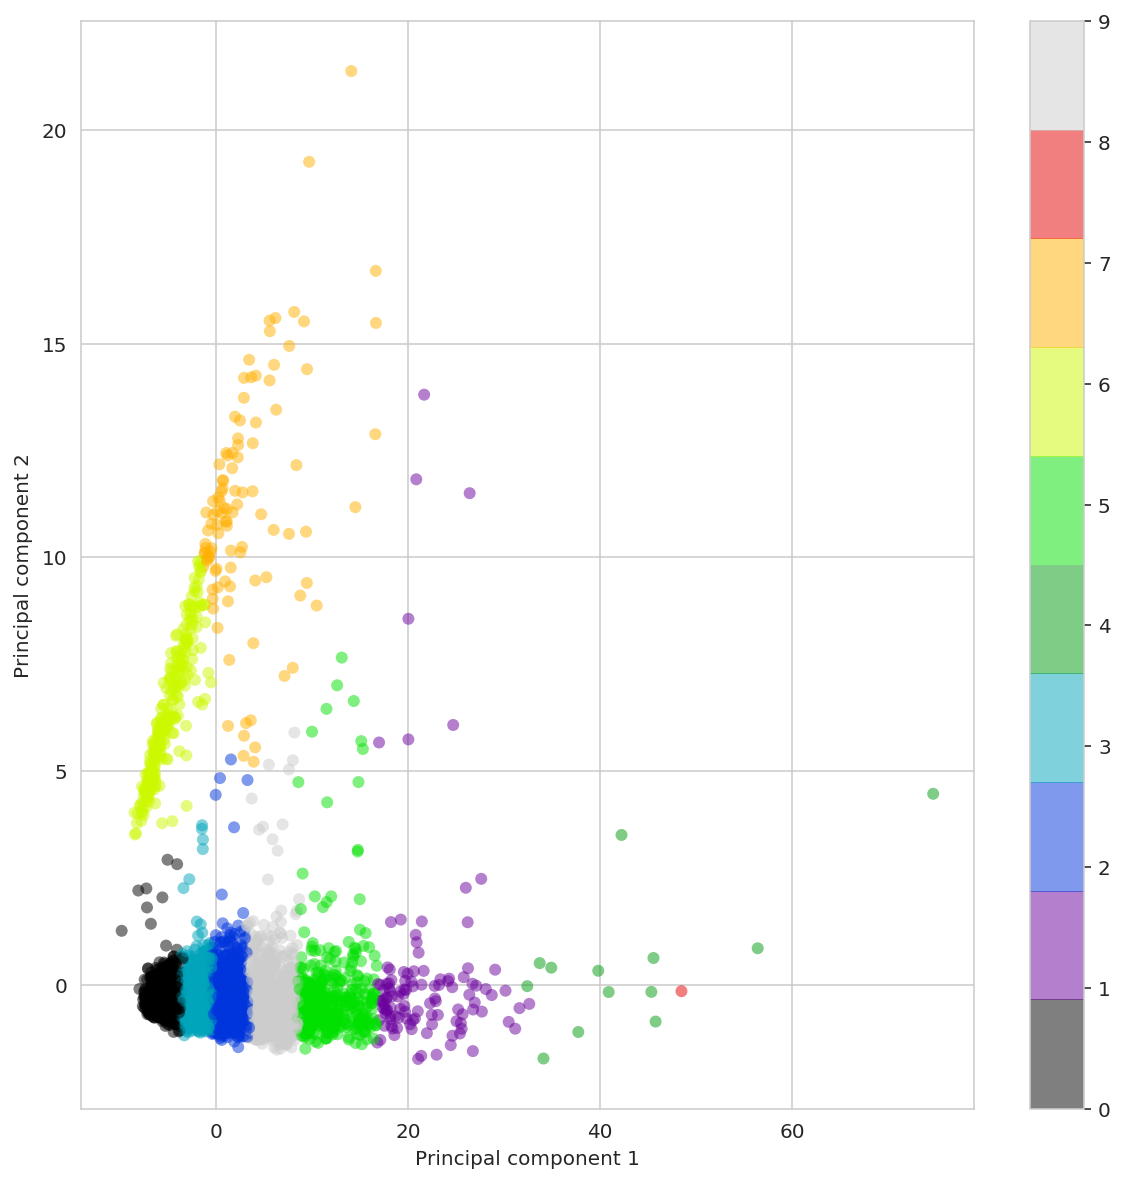

In [9]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import time

sns.set_style("whitegrid")
    
time_start = time.time()
# Number of dimensions recommended by Cell Ranger ATAC-Seq algorithm
# svd = TruncatedSVD(n_components=15)
# result = svd.fit_transform(normalized)
pca = PCA(n_components=15)
result = pca.fit_transform(normalized) # X : array-like, shape (n_samples, n_features)
print('Done! Time elapsed', time.time() - time_start)
print('Explained variation per principal components', np.sum(pca.explained_variance_ratio_))

# 2-10 clusters is recommened values by Cell Ranger ATAC-Seq
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(result)
y_kmeans = kmeans.predict(result)
cluster_counter = Counter()
for c in y_kmeans:
    cluster_counter['Cluster {}'.format(c)] +=1
print('Clustering', n_clusters)
for c, n in sorted(cluster_counter.items()):
    print(c, n)
    
cmap = plt.cm.get_cmap('nipy_spectral', len(set(y_kmeans)))
plt.figure(figsize=(10, 10))
plt.scatter(result[:, 0], result[:, 1], 
            c=y_kmeans, cmap=cmap, 
            edgecolor='none', alpha=0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.colorbar()
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7412 samples in 0.011s...
[t-SNE] Computed neighbors for 7412 samples in 0.610s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7412
[t-SNE] Computed conditional probabilities for sample 2000 / 7412
[t-SNE] Computed conditional probabilities for sample 3000 / 7412
[t-SNE] Computed conditional probabilities for sample 4000 / 7412
[t-SNE] Computed conditional probabilities for sample 5000 / 7412
[t-SNE] Computed conditional probabilities for sample 6000 / 7412
[t-SNE] Computed conditional probabilities for sample 7000 / 7412
[t-SNE] Computed conditional probabilities for sample 7412 / 7412
[t-SNE] Mean sigma: 0.501938
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.874535
[t-SNE] Error after 1000 iterations: 1.717427
t-SNE done! Time elapsed 148.84479522705078


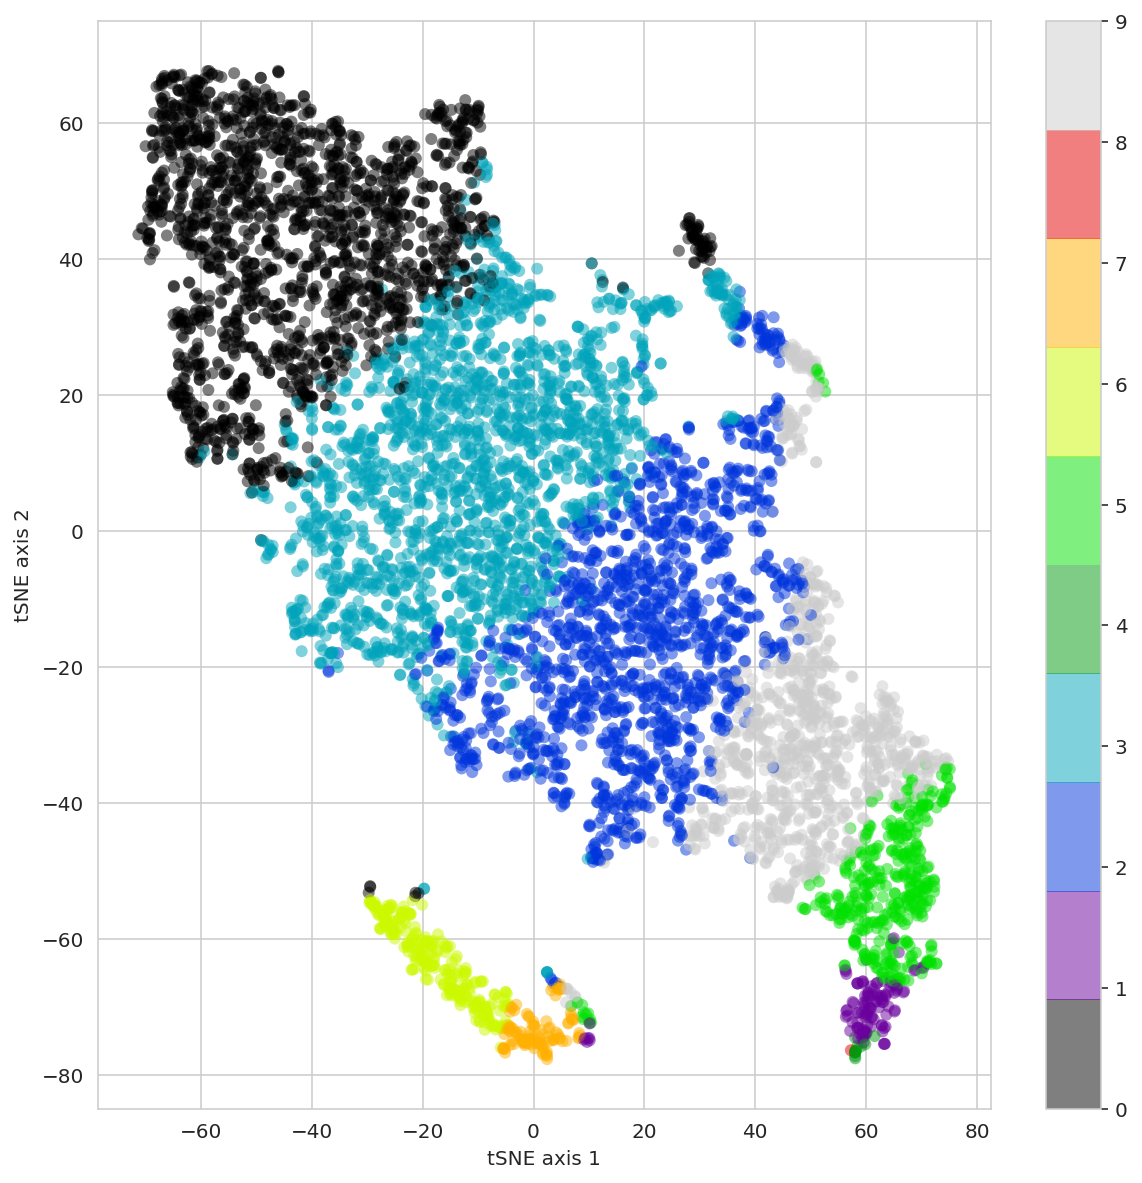

In [10]:
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(result)
print('t-SNE done! Time elapsed', time.time() - time_start)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], 
            c=y_kmeans, cmap=cmap,
            edgecolor='none', alpha=0.5)
plt.xlabel('tSNE axis 1')
plt.ylabel('tSNE axis 2')
plt.colorbar()
plt.show()

# Preparation the data for single cell explorer
Preprocess data for single cell explorer http://artyomovlab.wustl.edu/shiny/single_cell_explorer

In [20]:
from scipy import io, sparse

print('Save data_for_plot.tsv')
barcodes = fulldf.transpose().index.values
data_for_plot = pd.DataFrame(
    {'tSNE_1': tsne_results[:,0], 'tSNE_2': tsne_results[:,1], 'Cluster': y_kmeans})
data_for_plot.index = barcodes
data_for_plot.to_csv('data_for_plot.tsv', sep='\t')

print('Save expData.Rda.mtx')
# This produces huge tsv file
# fulldf.to_csv('expData.Rda.tsv', sep='\t')
csc = sparse.csc_matrix(fulldf.values)
io.mmwrite('expData.Rda.mtx', csc)

print('Save barcodes.txt')
with open('barcodes.txt', 'w') as f:
    for b in fulldf.columns.values:
        f.write(b + '\n')

print('Save peaks.txt')
with open('peaks.txt', 'w') as f:
    for p in fulldf.index.values:
        f.write(p + '\n')
        
print('Done')

Save data_for_plot.tsv
Save expData.Rda.mtx
Save barcodes.txt
Save peaks.txt
Done


## Convert to Rda format in R
```
require(readr)
require(Matrix)
library(magrittr)

barcodes <- readr::read_tsv('barcodes.txt', col_names = F)
peaks <- readr::read_tsv('peaks.txt', col_names = F)
mExpData <- Matrix::readMM('expData.Rda.mtx') %>%
    magrittr::set_rownames(peaks$X1) %>%
    magrittr::set_colnames(barcodes$X1)
save(mExpData, file = "expData.Rda")
```

Upload `data_for_plot.tsv` and `expData.Rda` to corresponding folder and voila! It works.

# Create BED files for clusters

In [ ]:
import os
import shutil

fulldft = fulldf.transpose()
results_dir = 'peaks_clusters'
if os.path.exists(results_dir):
    print('Cleanup', results_dir)
    shutil.rmtree(results_dir)

os.mkdir(results_dir)

for c in range(0, n_clusters):
    peaksdf = fulldft.loc[y_kmeans == c].mean()
    bed_file = os.path.join(results_dir, 'cluster_{}.bed'.format(c))
    print('Writing cluster', c, 'peaks to', bed_file)
    with open(bed_file, 'w') as bed:
        for (i, x) in enumerate(peaksdf):
            if x >= 1: 
                bed.write(re.sub(':|-', '\t', peaksdf.index[i]) + '\n')
print('Done')                